### Resources:
* [D-separation steps](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)
* [bnlearn datasets](https://www.bnlearn.com/bnrepository/)
* [Daggity paper](https://academic.oup.com/ije/article/45/6/1887/2907796)
* [Milestone](https://gitlab.pnnl.gov/y0-scuc/y0-archive/-/milestones/4)
* [pgmpy](https://github.com/pgmpy/pgmpy/blob/dev/examples/Creating%20a%20Discrete%20Bayesian%20Network.ipynb)  -- get_independencies

### TODO:
* Break into module, write proper unit tests
* What about conditional independencies?  Currently only covers independencies.  
   * Can I just enumerate tripples and check 'A,B given=["C"]'?  
   * Would then check combinations-pairs + combinations-givens 
   * Up to how many givens do you check?

In [1]:
import y0
from y0.util import CITests
import networkx as nx
import pandas as pd

from collections import abc
from itertools import combinations, chain

import seaborn as sns
%matplotlib inline

In [2]:
edges = [("A","C"), ("B","C"), ("C","D"), ("C","E"), ("D","F"), ("F","G")]
G = nx.DiGraph(edges)

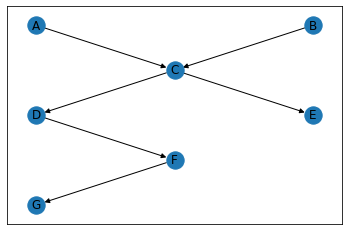

In [3]:
layout = {"A": (0,-1), "B": (2,-1), "C": (1,-2), "D": (0, -3), "E": (2, -3), "F":(1,-4), "G": (0,-5)}
nx.draw_networkx(G, pos=layout)

In [4]:
def are_d_separated(G, a,b, *, given=[]):
    """Tests if nodes named by a & b are d-separated in G.
    Given conditions can be provided with the optional 'given' parameter.
    returns T/F and the final graph (as evidence)
    """
    class Result:
        """By default, acts like a boolean, but also caries evidence graph."""
        def __init__(self, separated, a,b, given, evidence):
            """separated -- T/F judgement
               a/b/given -- The question asked
               evidence -- The end graph
            """
            self.separated=separated
            self.a = a
            self.b = b
            self.given = given
            self.evidence=evidence
        def __bool__(self): return self.separated
        def __repr__(self): return f"{repr(self.separated)} ('{a}' d-sep '{b}' given {given})"
        def __eq__(self, other): return self.separated == other
    
    named = set([a,b]).union(given)
    
    # Filter to ancestors
    keep = set(chain(*(nx.ancestors(G, n) for n in named))).union(named)
    G = nx.subgraph(G, keep).copy()

    # Moralize (link parents of mentioned nodes)
    in_edges = ([*G.in_edges(n)] for n in G)
    parents = ([*zip(*edges)][0] for edges in in_edges
                if len(edges)>0)
    augments = [*chain(*[combinations(nodes, 2) for nodes in parents])]
    G.add_edges_from(augments)
    
    # disorient & remove givens
    G = G.to_undirected()
    keep = set(G.nodes()) - set(given)
    G = G.subgraph(keep)

    # check for path....
    separated = not nx.has_path(G, a, b)   #If no path, then d-separated!
    
    return Result(separated, a, b, given, G)

In [5]:
#TODO: Convert to unit tests...
all([are_d_separated(G, "A", "B", given=["D", "F"]) == False,
     are_d_separated(G, "A", "B") == True,
     are_d_separated(G, "A", "B", given=["C"]) == False,
     are_d_separated(G, "D", "E", given=["C"]) == True,
     are_d_separated(G, "D", "E") == False,
     are_d_separated(G, "D", "E", given=["A", "B"]) == False,
     are_d_separated(G, "G", "G", given=["C"]) == False])

True

In [6]:
rslt = are_d_separated(G, "A", "B", given=["D", "F"])
rslt

False ('A' d-sep 'B' given ['D', 'F'])

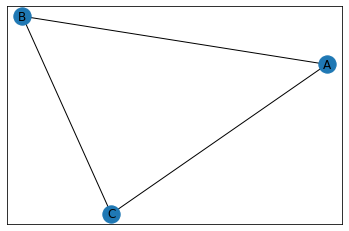

In [7]:
nx.draw_networkx(rslt.evidence)

In [8]:
def and_print(iterable, prefix="--"):
    it = iter(iterable)
    while it:
        try: v = next(it)
        except: return
        print(f"{prefix} {v}")
        yield v

        
def all_combinations(source, min=0, max=None):
    """Get successively longer combinations of the source.
    source -- List to get combinations from
    min -- smallest combination to get (default 0)
    max -- Largest combination to get (None means length of the list and is the default)
    """
    max = len(source) if max is None else max
    return [*chain(*(combinations(source, l) for l in range(min, max+1)))]
        

def falsifications(G, df, significance_level=.05, verbose=False, max_given=None):
    class Evidence(abc.Sequence):
        """A list of variables pairs that failed the d_sepration+covariance test.
        
        Has an extra 'evidence' property that is a dictionary.
          * Keys are the d-separated variable pairs
          * Values are the covariances measured between them.
          
        verbose -- print each combination as its checked
        max_given -- Longest list of 'given' variables to check
        """
        def __init__(self, failures, evidence):
            self._failures = failures
            self.evidence = evidence
        
        def __getitem__(self, i): return self._failures[i]
        def __len__(self): return len(self._failures)
        def __repr__(self): return repr(self._failures) + "+evidence"
    
    
    if verbose: wrapper=and_print
    else: wrapper=lambda v:v
        
    all_nodes = set(G.nodes)
    all_pairs = combinations(G.nodes, 2)
    to_test = [(a,b,given) for a,b in all_pairs
                  for given in all_combinations(all_nodes-{a,b}, max=max_given)
                if are_d_separated(G, a, b, given=given)]
    
    variances = {(a,b, given): CITests.cressie_read(a, b, given, df, boolean=False) 
                 for a, b, given in wrapper(to_test)}
    
    #TODO: Multiple-comparisons correction
    evidence = pd.DataFrame([(a, b, given, chi, p, dof) for (a, b, given), (chi, dof, p) in variances.items()],
                             columns=["A", "B", "Given", "chi^2", "p-value", "dof"])\
                    .pipe(lambda df: df.assign(flagged =(df["p-value"] < significance_level)))\
                    .sort_values(["flagged", "dof"], ascending=False)
    
    failures = evidence[evidence["flagged"]][["A", "B", "Given"]].apply(tuple, axis="columns")
    return Evidence(failures, evidence)
    


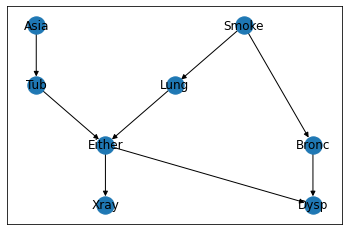

In [9]:
edges = [("Asia", "Tub"), 
         ("Smoke", "Lung"), ("Smoke", "Bronc"),
         ("Tub", "Either"),
         ("Lung", "Either"),
         ("Either", "Xray"), ("Either", "Dysp"),
         ("Bronc", "Dysp")]
layout = {"Asia": (0,0),
          "Smoke": (3,0),
          "Tub": (0, -1),
          "Lung": (2, -1),
          "Either": (1, -2),
          "Bronc": (4, -2),
          "Xray": (1, -3),
          "Dysp": (4, -3)}
asia_G = nx.DiGraph(edges)
asia_df = pd.read_csv("asia.csv", index_col=0)\
            .replace({"yes":1, "no":-1})
nx.draw_networkx(asia_G, pos=layout)

In [10]:
#Should be no issues here...
issues = falsifications(asia_G, asia_df, max_given=2)

In [11]:
issues

21          (Asia, Lung, (Tub, Xray))
118      (Lung, Bronc, (Smoke, Asia))
41        (Asia, Either, (Tub, Xray))
79             (Tub, Bronc, (Smoke,))
82      (Tub, Bronc, (Either, Smoke))
86        (Tub, Bronc, (Smoke, Xray))
116    (Lung, Bronc, (Either, Smoke))
132    (Bronc, Either, (Smoke, Lung))
93        (Tub, Xray, (Either, Lung))
dtype: object+evidence

In [12]:
asia_df.shape

(5000, 8)

In [13]:
issues.evidence

,A,B,Given,chi^2,p-value,dof,flagged
21,Asia,Lung,"(Tub, Xray)",8.428397,0.037940,3,True
118,Lung,Bronc,"(Smoke, Asia)",8.043061,0.045130,3,True
41,Asia,Either,"(Tub, Xray)",7.857395,0.019669,2,True
79,Tub,Bronc,"(Smoke,)",7.359856,0.025225,2,True
82,Tub,Bronc,"(Either, Smoke)",9.686306,0.007882,2,True
...,...,...,...,...,...,...,...
136,Bronc,Either,"(Lung, Xray)",0.706064,0.400754,1,False
39,Asia,Either,"(Tub, Lung)",0.000000,NaN,0,False
99,Smoke,Either,"(Tub, Lung)",0.000000,NaN,0,False
123,Lung,Xray,"(Either, Tub)",0.000000,NaN,0,False


In [14]:
# Should be issues (Lung, Either) AT LEAST.
#.  Seeing issues (Lung, Xray) as well.  Is that all? 
# TODO: Check d-separations by hand...
asia_G2 = asia_G.copy()
asia_G2.remove_edge("Lung", "Either")
issues = falsifications(asia_G2, asia_df, max_given=2)
issues

115        (Tub, Lung, (Dysp, Bronc))
157    (Smoke, Either, (Dysp, Bronc))
163    (Smoke, Either, (Asia, Bronc))
179      (Smoke, Xray, (Dysp, Bronc))
184      (Smoke, Xray, (Asia, Bronc))
                    ...              
219              (Lung, Xray, (Tub,))
246               (Bronc, Either, ())
248           (Bronc, Either, (Tub,))
262                 (Bronc, Xray, ())
265             (Bronc, Xray, (Tub,))
Length: 106, dtype: object+evidence